# Video visualization

In this tutorial we'll see how to inject a video visualizer into a simulation.

First some boilerplate:

In [ ]:
import brian2.only as b2
from brian2 import np
import matplotlib.pyplot as plt

import cleo

cleo.utilities.style_plots_for_docs()

# numpy faster than cython for lightweight example
b2.prefs.codegen.target = "numpy"
# for reproducibility
np.random.seed(17230616)
cleo.utilities.set_seed(17900717)

c_exc = "xkcd:tomato"
c_inh = "xkcd:cerulean blue"

## Set up the simulation

### Network

We'll use excitatory and inhibitory populations of [exponential integrate-and-fire neurons](https://neuronaldynamics.epfl.ch/online/Ch5.S2.html).

In [ ]:
b2.defaultclock.dt = 0.5 * b2.ms
n_e = 400
n_i = n_e // 4


def eif(n, name):
    ng = b2.NeuronGroup(
        n,
        """
        dv/dt = (-(v - E_L) + Delta_T*exp((v-theta)/Delta_T) + Rm*I) / tau_m : volt
        I : amp
        """,
        threshold="v>30*mV",
        reset="v=-55*mV",
        namespace={
            "tau_m": 20 * b2.ms,
            "Rm": 500 * b2.Mohm,
            "theta": -50 * b2.mV,
            "Delta_T": 2 * b2.mV,
            "E_L": -70 * b2.mV,
        },
        name=name,
    )
    ng.v = -70 * b2.mV
    return ng


exc = eif(n_e, "exc")
inh = eif(n_i, "inh")
W = 250
p_S = 0.3
S_ei = b2.Synapses(exc, inh, on_pre="v_post+=W*mV/n_e")
S_ei.connect(p=p_S)
S_ie = b2.Synapses(inh, exc, on_pre="v_post-=W*mV/n_i")
S_ie.connect(p=p_S)
S_ee = b2.Synapses(exc, exc, on_pre="v_post+=W*mV/n_e")
S_ee.connect(condition="abs(i-j)<=20")

mon_e = b2.SpikeMonitor(exc)
mon_i = b2.SpikeMonitor(inh)

net = b2.Network(exc, inh, S_ei, S_ie, S_ee, mon_e, mon_i)

### Coordinates and optogenetics
Here we configure the coordinates and optogenetic stimulation. For more details, see the ["Optogenetic stimulation" tutorial](optogenetics). Note that we save the arguments used in the plotting function for reuse later on when generating the video.

In [ ]:
from cleo.coords import assign_coords_uniform_cylinder
from cleo.viz import plot

r = 1
assign_coords_uniform_cylinder(
    exc, xyz_start=(0, 0, 0.3), xyz_end=(0, 0, 0.4), radius=r
)
assign_coords_uniform_cylinder(
    inh, xyz_start=(0, 0, 0.3), xyz_end=(0, 0, 0.4), radius=r
)

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='x (um)', ylabel='y (um)', zlabel='z (um)'>)

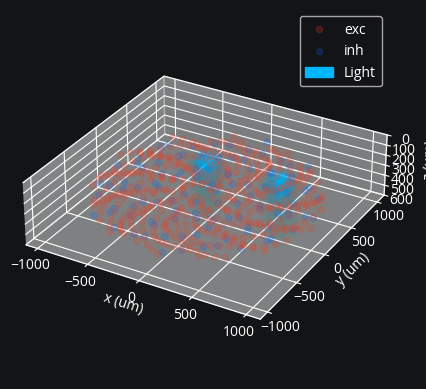

In [ ]:
from cleo.opto import chr2_4s
from cleo.light import fiber473nm, Light

opsin = chr2_4s()
fibers = Light(
    coords=[[0, 0, 0], [700, 0, 0]] * b2.um,
    light_model=fiber473nm(),
    max_value=30 * b2.mwatt / b2.mm2,
    save_history=True,
)

plotargs = {
    "colors": [c_exc, c_inh],
    "zlim": (0, 600),
    "scatterargs": {"s": 20},  # to adjust neuron marker size
    "axis_scale_unit": b2.um,
}

plot(
    exc,
    inh,
    **plotargs,
    devices=[fibers],
)

### Simulator, optogenetics injection
Here we create the simulator and inject the opsin and light source:

In [ ]:
sim = cleo.CLSimulator(net)
sim.inject(opsin, exc, Iopto_var_name="I")
sim.inject(fibers, exc)

CLSimulator(io_processor=None, devices={Light(name='Light', save_history=True, value=array([0., 0.]), light_model=OpticFiber(R0=100. * umetre, NAfib=0.37, K=125. * metre ** -1, S=7370. * metre ** -1, ntis=1.36), wavelength=0.473 * umetre, direction=array([0., 0., 1.]), max_value=30. * mwatt / mmetre2, max_value_viz=None), FourStateOpsin(name='ChR2', save_history=True, on_pre='', spectrum=[(400, 0.34), (422, 0.65), (460, 0.96), (470, 1), (473, 1), (500, 0.57), (520, 0.22), (540, 0.06), (560, 0.01), (800, 1.257478763901864e-06), (844, 2.404003519224151e-06), (920, 3.5505282745464387e-06), (940, 3.6984669526525404e-06), (946, 3.6984669526525404e-06), (1000, 2.1081261630119477e-06), (1040, 8.136627295835588e-07), (1080, 2.2190801715915242e-07), (1120, 3.69846695265254e-08)], extrapolate=False, required_vars=[('Iopto', amp), ('v', volt)], g0=114. * nsiemens, gamma=0.00742, phim=2.33e+23 * (second ** -1) / (meter ** 2), k1=4.15 * khertz, k2=0.868 * khertz, p=0.833, Gf0=37.3 * hertz, kf=58.1 

### Processor
And we set up open-loop optogenetic stimulation:

In [ ]:
fibers.update([5, 0] * b2.mwatt / b2.mm2)


class OpenLoopOpto(cleo.ioproc.LatencyIOProcessor):
    def process(self, state_dict, t):
        # random walk stimulation
        fiber_intensities = (
            fibers.irradiance[-1] + np.random.randn(2) * 0.5 * b2.mwatt / b2.mm2
        )
        fiber_intensities[fiber_intensities < 0] = 0
        if t > 50 * b2.ms:
            fiber_intensities = [0, 5] * b2.mwatt / b2.mm2
        return ({"Light": fiber_intensities}, t)


sim.set_io_processor(OpenLoopOpto(sample_period=1 * b2.ms))

CLSimulator(io_processor=OpenLoopOpto(sample_period=1. * msecond, sampling='fixed', processing='parallel'), devices={Light(name='Light', save_history=True, value=array([5., 0.]), light_model=OpticFiber(R0=100. * umetre, NAfib=0.37, K=125. * metre ** -1, S=7370. * metre ** -1, ntis=1.36), wavelength=0.473 * umetre, direction=array([0., 0., 1.]), max_value=30. * mwatt / mmetre2, max_value_viz=None), FourStateOpsin(name='ChR2', save_history=True, on_pre='', spectrum=[(400, 0.34), (422, 0.65), (460, 0.96), (470, 1), (473, 1), (500, 0.57), (520, 0.22), (540, 0.06), (560, 0.01), (800, 1.257478763901864e-06), (844, 2.404003519224151e-06), (920, 3.5505282745464387e-06), (940, 3.6984669526525404e-06), (946, 3.6984669526525404e-06), (1000, 2.1081261630119477e-06), (1040, 8.136627295835588e-07), (1080, 2.2190801715915242e-07), (1120, 3.69846695265254e-08)], extrapolate=False, required_vars=[('Iopto', amp), ('v', volt)], g0=114. * nsiemens, gamma=0.00742, phim=2.33e+23 * (second ** -1) / (meter **

## Inject VideoVisualizer

A {class}`~cleo.viz.VideoVisualizer` is an {class}`~cleo.InterfaceDevice` like recorders and stimulators and needs to be injected in order to properly interact with the Brian network.
Keep in mind the following:

- It must be injected *after* all other devices for the `devices='all'` argument to work as expected.  
- Similarly to recording and stimulation, you must specify the target neuron groups (to display, in this case) on injection
- The `dt` argument makes a huge difference on the amount of time it takes to generate the video. You may want to keep this high while experimenting and only lower it when you are ready to generate a high-quality video since the process is so slow.

In [ ]:
vv = cleo.viz.VideoVisualizer(dt=1 * b2.ms, devices="all")
sim.inject(vv, exc, inh)

CLSimulator(io_processor=OpenLoopOpto(sample_period=1. * msecond, sampling='fixed', processing='parallel'), devices={VideoVisualizer(name='VideoVisualizer', save_history=True, devices=[Light(name='Light', save_history=True, value=array([5., 0.]), light_model=OpticFiber(R0=100. * umetre, NAfib=0.37, K=125. * metre ** -1, S=7370. * metre ** -1, ntis=1.36), wavelength=0.473 * umetre, direction=array([0., 0., 1.]), max_value=30. * mwatt / mmetre2, max_value_viz=None)], dt=1. * msecond, fig=None, ax=None, neuron_groups=[NeuronGroup(clock=Clock(dt=0.5 * msecond, name='defaultclock'), when=start, order=0, name='exc'), NeuronGroup(clock=Clock(dt=0.5 * msecond, name='defaultclock'), when=start, order=0, name='inh')], _spike_mons=[<SpikeMonitor, recording from 'spikemonitor_2'>, <SpikeMonitor, recording from 'spikemonitor_3'>], _num_old_spikes=[0, 0], _value_per_device_per_frame=[], _i_spikes_per_ng_per_frame=[]), Light(name='Light', save_history=True, value=array([5., 0.]), light_model=OpticFib

## Run simulation and visualize

Here we display a quick plot before generating the video:

In [ ]:
T = 100 * b2.ms
sim.run(T)

WARNING    'T' is an internal variable of group 'light_prop_ChR2_exc', but also exists in the run namespace with the value 100. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


INFO       No numerical integration method specified for group 'exc', using method 'euler' (took 0.05s, trying other methods took 0.13s). [brian2.stateupdaters.base.method_choice]


INFO       No numerical integration method specified for group 'inh', using method 'euler' (took 0.01s, trying other methods took 0.04s). [brian2.stateupdaters.base.method_choice]


INFO       No numerical integration method specified for group 'syn_ChR2_exc', using method 'euler' (took 0.06s, trying other methods took 0.20s). [brian2.stateupdaters.base.method_choice]


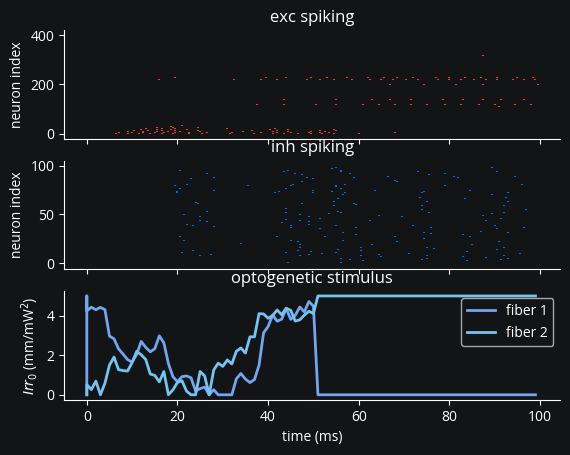

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
sptexc = mon_e.spike_trains()
ax1.eventplot(
    [t / b2.ms for t in sptexc.values()], lineoffsets=list(sptexc.keys()), color=c_exc
)
ax1.set(ylabel="neuron index", title="exc spiking")
sptinh = mon_i.spike_trains()
ax2.eventplot(
    [t / b2.ms for t in sptinh.values()], lineoffsets=list(sptinh.keys()), color=c_inh
)
ax2.set(ylabel="neuron index", title="inh spiking")
ax3.plot(fibers.t / b2.ms, fibers.irradiance_[:, 0], c="#72a5f2", lw=2, label="fiber 1")
ax3.plot(fibers.t / b2.ms, fibers.irradiance_[:, 1], c="#72c5f2", lw=2, label="fiber 2")
ax3.legend()
ax3.set(
    ylabel=r"$Irr_0$ (mm/mW$^2$)", title="optogenetic stimulus", xlabel="time (ms)"
);

The {class}`~cleo.viz.VideoVisualizer` stores the data it needs during the simulation, but hasn't yet produced any visual output.
We first use the {meth}`~cleo.viz.VideoVisualizer.generate_Animation` method, plugging in the arguments we used for the original plot.

Also, we set the {attr}`~cleo.light.Light.max_value_viz` attribute of the light.
This effectively scales how bright the light appears in the visualization.
That is, a high maximum irradiance makes the stimulus values small in comparison and produces a faint light, while a low ceiling makes the values relatively large and produces a bright light in the resulting video.

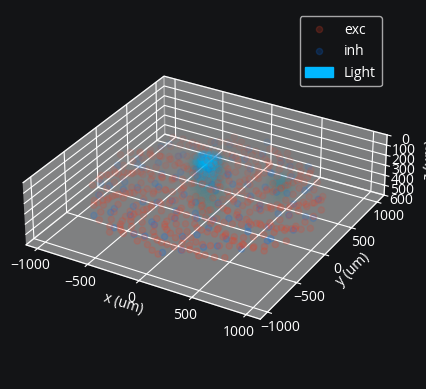

In [ ]:
fibers.max_value_viz = np.max(fibers.irradiance)
ani = vv.generate_Animation(plotargs, slowdown_factor=10)

{meth}`~cleo.viz.VideoVisualizer.generate_Animation` returns a matplotlib [`FuncAnimation` object](https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html), which you can then use however you want. 
You will probably want to [save a video](https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.Animation.html#matplotlib.animation.Animation.save).

Note that at this point the video still hasn't been rendered; that happens when you try and save or visualize the animation.
This step takes a while if your temporal resolution is high, so we suggest you do this only after your experiment is finalized and after you've experimented with low framerate videos to finalize video parameters.

Here we embed the video using HTML so you can see the output:

In [ ]:
from IPython.display import display, HTML

ani_html = HTML(ani.to_html5_video())
display(ani_html)